In [440]:
import numpy as np 
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize
import folium

First, Iam going to load the data related to foreigners living in Prague. Main source of data is Czech Statistical Bureau, data can be found here: https://www.czso.cz/csu/czso/otevrena-data-v-katalogu-produktu-csu?filtr=true&skupiny=29&vlastnosti=22. Data has been cleaned before reading to pandas dataframe.

In [1125]:
Foreigners = pd.read_csv('C:/Users/LuciaBenisova/Documents/Cizinci1.csv')
Foreigners_top5= pd.read_csv('C:/Users/LuciaBenisova/Documents/Cizinci1.csv').head(5)
Foreigners_top5

,Ctry,2016,2017,Total
0,UA,189112,194924,384036
1,SK,116272,121164,237436
2,RU,89028,91864,180892
3,VN,48848,50444,99292
4,CN,17120,19292,36412


Based on the data I got, we can say that top 5 foreigners communities can be split in two major groups, A) Slavic Countries (Ukraine, Slovak Republic and Russia) and B) Asian countries (Vietnam, China). Now, the goal will be to find out, whether we can see traces of Slavic and Asian cuisine in Prague food market.

I am going to loaded Geo data related to Prague districts Data has been scraped from www.wikipedia and pre-processesd. 

In [1126]:
PragueDistricts = pd.read_excel('C:/Users/LuciaBenisova/Documents/Prague_Districts.xlsx')
PragueDistricts.head()

,Prague_District,latitude,longitude
0,Prague 1,50.087838,14.424132
1,Prague 2,50.073584,14.429493
2,Prague 3,50.084426,14.470404
3,Prague 4,50.012278,14.474770
4,Prague 5,50.037601,14.359204


Let's visualize the Prague Districtcs using Folium.

In [1127]:
map_praguedistrictcs = folium.Map(location=[50.087838,14.424132], zoom_start=10)
for lat, lng, label in zip(PragueDistricts['latitude'], PragueDistricts['longitude'], PragueDistricts['Prague_District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_praguedistrictcs)
map_praguedistrictcs

As a next step, I will check the venues located within the Prague Districts higlighted above. But let the set up Foresquare API connection before.

In [1129]:
CLIENT_ID = 'G0UDA5V0QKQYTPYWMVYVUKDY02BHOFJ13WCR415TFJZSSBHR' # your Foursquare ID
CLIENT_SECRET = 'HIQOJPCSUFQA0YU50PZCN5J0DS21E3IRXFHF2AX1C4B0GG4B' # your Foursquare Secret
VERSION = '20192304' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G0UDA5V0QKQYTPYWMVYVUKDY02BHOFJ13WCR415TFJZSSBHR
CLIENT_SECRET:HIQOJPCSUFQA0YU50PZCN5J0DS21E3IRXFHF2AX1C4B0GG4B


Now I am going to pull list of venues based in Prague that are recognized by Foresquare API.

In [1130]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [1190]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        LIMIT = 100 # limit of number of venues returned by Foursquare API
        radius = 1000 # define radius
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Prague_District', 
                  'latitude', 
                  'longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1191]:
prague_districts_venues = getNearbyVenues(names=PragueDistricts['Prague_District'],
                                   latitudes=PragueDistricts['latitude'],
                                   longitudes=PragueDistricts['longitude']
                                  )

Prague 1
Prague 2
Prague 3
Prague 4
Prague 5
Prague 6
Prague 7
Prague 8
Prague 9
Prague 10
Prague 11
Prague 12
Prague 13
Prague 14
Prague 15
Prague 16
Prague 17
Prague 18
Prague 19
Prague 20
Prague 21
Prague 22


In [1192]:
print(prague_districts_venues.shape)
prague_districts_venues.head()

(1071, 7)


,Prague_District,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Prague 1,50.087838,14.424132,Yami Sushi House,50.089428,14.423481,Sushi Restaurant
1,Prague 1,50.087838,14.424132,Pot au Feu,50.089119,14.426156,French Restaurant
2,Prague 1,50.087838,14.424132,Euro Segway Prague,50.088360,14.423203,Travel Agency
3,Prague 1,50.087838,14.424132,Staroměstské náměstí | Old Town Square (Starom...,50.087493,14.421091,Plaza
4,Prague 1,50.087838,14.424132,Maitrea,50.088428,14.422510,Vegetarian / Vegan Restaurant


In [1231]:
prague_districts_venues['Venue Category'].value_counts()

Restaurant                       54
Bus Stop                         51
Café                             49
Hotel                            30
Pub                              27
Czech Restaurant                 27
Coffee Shop                      24
Pizza Place                      24
Gym / Fitness Center             23
Italian Restaurant               22
Park                             22
Vietnamese Restaurant            22
Supermarket                      20
Bakery                           19
Cocktail Bar                     17
Athletics & Sports               14
Clothing Store                   14
Bistro                           14
Dessert Shop                     13
Plaza                            11
Wine Bar                         11
Bar                              11
Chinese Restaurant                9
Vegetarian / Vegan Restaurant     9
Furniture / Home Store            9
Grocery Store                     8
Steakhouse                        8
Sporting Goods Shop         

In [1193]:
prague_districts_venues.groupby('Prague_District').count()

,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Prague_District,,,,,,
Prague 1,100,100,100,100,100,100
Prague 10,47,47,47,47,47,47
Prague 11,32,32,32,32,32,32
Prague 12,50,50,50,50,50,50
Prague 13,33,33,33,33,33,33
Prague 14,36,36,36,36,36,36
Prague 15,33,33,33,33,33,33
Prague 16,48,48,48,48,48,48
Prague 17,34,34,34,34,34,34


In [1194]:
print('There are {} uniques categories, including food industry venues.'.format(len(prague_districts_venues['Venue Category'].unique())))

There are 240 uniques categories, including food industry venues.


In [1195]:
prague_districts_venues.to_csv('C:/Users/LuciaBenisova/Documents/prague_districts_venues.csv')

Since I am interested to analyze restaurants primarily, I am going to flag this specific venues in the dataframe so from now on I can be working only with these items.

In [1196]:
prague_districts_venues['RestaurantFlag'] = np.where(prague_districts_venues['Venue Category'].str.contains("Restaurant", case=False, na=False), 'Y', '')
prague_districts_restaurants = prague_districts_venues[prague_districts_venues['RestaurantFlag'] == 'Y'].reset_index(drop=True)
prague_districts_restaurants.head()

,Prague_District,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,RestaurantFlag
0,Prague 1,50.087838,14.424132,Yami Sushi House,50.089428,14.423481,Sushi Restaurant,Y
1,Prague 1,50.087838,14.424132,Pot au Feu,50.089119,14.426156,French Restaurant,Y
2,Prague 1,50.087838,14.424132,Maitrea,50.088428,14.422510,Vegetarian / Vegan Restaurant,Y
3,Prague 1,50.087838,14.424132,Pasta Fresca,50.087216,14.423773,Italian Restaurant,Y
4,Prague 1,50.087838,14.424132,Zdenek's Oyster Bar,50.088259,14.424579,Seafood Restaurant,Y


In [1138]:
prague_districts_restaurants_onehot = pd.get_dummies(prague_districts_restaurants[['Venue Category']], prefix="", prefix_sep="")
prague_districts_restaurants_onehot['Prague_District'] = prague_districts_restaurants['Prague_District'] 
fixed_columns = [prague_districts_restaurants_onehot.columns[-1]] + list(prague_districts_restaurants_onehot.columns[:-1])
prague_districts_restaurants_onehot = prague_districts_restaurants_onehot[fixed_columns]

prague_districts_restaurants_onehot.head()

,Prague_District,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caucasian Restaurant,Chinese Restaurant,Czech Restaurant,Doner Restaurant,Eastern European Restaurant,...,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Prague 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Prague 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Prague 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Prague 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Prague 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [1197]:
prague_districts_restaurants_onehot.shape

(298, 33)

In [1198]:
prague_districts_restaurants_grouped = prague_districts_restaurants_onehot.groupby('Prague_District').mean().reset_index()
prague_districts_restaurants_grouped

,Prague_District,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caucasian Restaurant,Chinese Restaurant,Czech Restaurant,Doner Restaurant,Eastern European Restaurant,...,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Prague 1,0.043478,0.043478,0.000000,0.086957,0.000000,0.000000,0.086957,0.000000,0.000000,...,0.000000,0.173913,0.000000,0.000000,0.043478,0.086957,0.000000,0.000000,0.043478,0.086957
1,Prague 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.095238,0.047619,0.000000,...,0.000000,0.285714,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.142857
2,Prague 11,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.222222,0.000000,0.000000,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000
3,Prague 12,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Prague 13,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.176471,0.000000,0.000000,...,0.000000,0.235294,0.000000,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.058824
5,Prague 14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,...,0.000000,0.666667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Prague 15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,...,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Prague 16,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
8,Prague 17,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.272727,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909
9,Prague 18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [1199]:
prague_districts_restaurants.shape

(211, 8)

In [1200]:
num_top_restaurants = 5

for hood in prague_districts_restaurants_grouped['Prague_District']:
    print("----"+hood+"----")
    temp = prague_districts_restaurants_grouped[prague_districts_restaurants_grouped['Prague_District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_restaurants))
    print('\n')

----Prague 1----
                   venue  freq
0     Italian Restaurant  0.22
1             Restaurant  0.17
2  Vietnamese Restaurant  0.09
3   Brazilian Restaurant  0.09
4       Sushi Restaurant  0.09


----Prague 10----
                   venue  freq
0             Restaurant  0.29
1  Vietnamese Restaurant  0.14
2     Chinese Restaurant  0.14
3       Kebab Restaurant  0.10
4       Czech Restaurant  0.10


----Prague 11----
                  venue  freq
0            Restaurant  0.33
1      Czech Restaurant  0.22
2  Fast Food Restaurant  0.11
3    Turkish Restaurant  0.11
4    Chinese Restaurant  0.11


----Prague 12----
                      venue  freq
0                Restaurant  0.43
1      Fast Food Restaurant  0.14
2        Chinese Restaurant  0.14
3        Italian Restaurant  0.14
4  Mediterranean Restaurant  0.14


----Prague 13----
                  venue  freq
0            Restaurant  0.24
1  Fast Food Restaurant  0.18
2      Czech Restaurant  0.18
3    Italian Restaurant  0.

In [1201]:
def return_most_common_restaurants(row, num_top_restaurants):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_restaurants]

In [1234]:
num_top_restaurants = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Prague_District']
for ind in np.arange(num_top_restaurants):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
prague_districts_restaurants_sorted = pd.DataFrame(columns=columns)
prague_districts_restaurants_sorted['Prague_District'] = prague_districts_restaurants_grouped['Prague_District']

for ind in np.arange(prague_districts_restaurants_grouped.shape[0]):
    prague_districts_restaurants_sorted.iloc[ind, 1:] = return_most_common_restaurants(prague_districts_restaurants_grouped.iloc[ind, :], num_top_restaurants)

prague_districts_restaurants_sorted.head()

,Prague_District,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Prague 1,Italian Restaurant,Restaurant,Vietnamese Restaurant,Brazilian Restaurant,Sushi Restaurant,Czech Restaurant,Mexican Restaurant,Asian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant
1,Prague 10,Restaurant,Vietnamese Restaurant,Chinese Restaurant,Czech Restaurant,Mexican Restaurant,Kebab Restaurant,Sushi Restaurant,Mediterranean Restaurant,Doner Restaurant,Scandinavian Restaurant
2,Prague 11,Restaurant,Czech Restaurant,Turkish Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Doner Restaurant,Indian Restaurant,French Restaurant,Eastern European Restaurant
3,Prague 12,Restaurant,Italian Restaurant,Mediterranean Restaurant,Chinese Restaurant,Fast Food Restaurant,Doner Restaurant,Indian Restaurant,French Restaurant,Eastern European Restaurant,Vietnamese Restaurant
4,Prague 13,Restaurant,Fast Food Restaurant,Czech Restaurant,Italian Restaurant,Scandinavian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Sushi Restaurant,Brazilian Restaurant


In [1235]:
prague_districts_restaurants_grouped_clusters = prague_districts_restaurants_grouped.drop('Prague_District', 1)

Text(0.5,1,'Elbow curve')

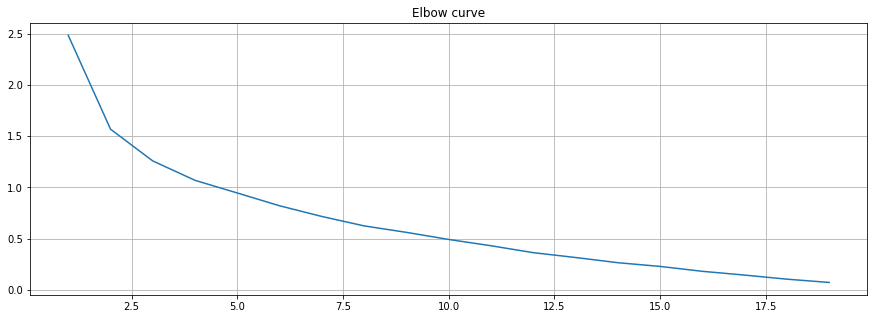

In [1236]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = prague_districts_restaurants_grouped_clusters
distorsions = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1,20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [1238]:
# set number of clusters
kclusters = 2
prague_districts_restaurants_grouped_clusters = prague_districts_restaurants_grouped.drop('Prague_District', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(prague_districts_restaurants_grouped_clusters)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [1245]:
#prague_districts_restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
prague_districtcs_merged = PragueDistricts
prague_districtcs_merged = prague_districtcs_merged.join(prague_districts_restaurants_sorted.set_index('Prague_District'), on='Prague_District')
prague_districtcs_merged.head()

,Prague_District,latitude,longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Prague 1,50.087838,14.424132,0,Italian Restaurant,Restaurant,Vietnamese Restaurant,Brazilian Restaurant,Sushi Restaurant,Czech Restaurant,Mexican Restaurant,Asian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant
1,Prague 2,50.073584,14.429493,0,Modern European Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Belgian Restaurant,Ramen Restaurant,Portuguese Restaurant
2,Prague 3,50.084426,14.470404,0,Restaurant,Asian Restaurant,Vietnamese Restaurant,Indian Restaurant,Sushi Restaurant,Italian Restaurant,Doner Restaurant,Mexican Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant
3,Prague 4,50.012278,14.474770,0,Vietnamese Restaurant,Asian Restaurant,Restaurant,Czech Restaurant,Chinese Restaurant,Javanese Restaurant,Belgian Restaurant,Brazilian Restaurant,Caucasian Restaurant,Doner Restaurant
4,Prague 5,50.037601,14.359204,0,Czech Restaurant,Chinese Restaurant,Restaurant,Kebab Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant


In [1251]:
# create map
map_clusters = folium.Map(location=[50.087838,14.424132], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prague_districtcs_merged['latitude'], prague_districtcs_merged['longitude'], prague_districtcs_merged['Prague_District'], prague_districtcs_cleaned['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [1248]:
prague_districtcs_merged.loc[prague_districtcs_merged['Cluster Labels'] == 0, prague_districtcs_merged.columns[[0,3] + list(range(4, prague_districtcs_merged.shape[1]))]]

,Prague_District,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Prague 1,0,Italian Restaurant,Restaurant,Vietnamese Restaurant,Brazilian Restaurant,Sushi Restaurant,Czech Restaurant,Mexican Restaurant,Asian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant
1,Prague 2,0,Modern European Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Belgian Restaurant,Ramen Restaurant,Portuguese Restaurant
2,Prague 3,0,Restaurant,Asian Restaurant,Vietnamese Restaurant,Indian Restaurant,Sushi Restaurant,Italian Restaurant,Doner Restaurant,Mexican Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant
3,Prague 4,0,Vietnamese Restaurant,Asian Restaurant,Restaurant,Czech Restaurant,Chinese Restaurant,Javanese Restaurant,Belgian Restaurant,Brazilian Restaurant,Caucasian Restaurant,Doner Restaurant
4,Prague 5,0,Czech Restaurant,Chinese Restaurant,Restaurant,Kebab Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant
5,Prague 6,0,Restaurant,Czech Restaurant,Chinese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Asian Restaurant,Italian Restaurant,Caucasian Restaurant
6,Prague 7,0,Vietnamese Restaurant,Italian Restaurant,Indian Restaurant,Asian Restaurant,Japanese Restaurant,Modern European Restaurant,Czech Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant
8,Prague 9,0,Restaurant,Czech Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Brazilian Restaurant,Caucasian Restaurant,Belgian Restaurant
9,Prague 10,0,Restaurant,Vietnamese Restaurant,Chinese Restaurant,Czech Restaurant,Mexican Restaurant,Kebab Restaurant,Sushi Restaurant,Mediterranean Restaurant,Doner Restaurant,Scandinavian Restaurant
10,Prague 11,0,Restaurant,Czech Restaurant,Turkish Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Doner Restaurant,Indian Restaurant,French Restaurant,Eastern European Restaurant


In [1247]:
prague_districtcs_merged.loc[prague_districtcs_merged['Cluster Labels'] == 1, prague_districtcs_merged.columns[[0,3] + list(range(4, prague_districtcs_merged.shape[1]))]]

,Prague_District,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
7,Prague 8,1,Restaurant,Asian Restaurant,Czech Restaurant,Chinese Restaurant,Doner Restaurant,Eastern European Restaurant,Italian Restaurant,Vietnamese Restaurant,Javanese Restaurant,Belgian Restaurant
11,Prague 12,1,Restaurant,Italian Restaurant,Mediterranean Restaurant,Chinese Restaurant,Fast Food Restaurant,Doner Restaurant,Indian Restaurant,French Restaurant,Eastern European Restaurant,Vietnamese Restaurant
13,Prague 14,1,Restaurant,Italian Restaurant,Eastern European Restaurant,Russian Restaurant,Czech Restaurant,Indian Restaurant,French Restaurant,Fast Food Restaurant,Doner Restaurant,Vietnamese Restaurant
14,Prague 15,1,Restaurant,Mexican Restaurant,Italian Restaurant,Czech Restaurant,Doner Restaurant,Indian Restaurant,French Restaurant,Fast Food Restaurant,Eastern European Restaurant,Vietnamese Restaurant
17,Prague 18,1,Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Doner Restaurant,Italian Restaurant,Indian Restaurant,French Restaurant,Eastern European Restaurant,Vietnamese Restaurant,Javanese Restaurant
18,Prague 19,1,Restaurant,Chinese Restaurant,Vietnamese Restaurant,Javanese Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caucasian Restaurant,Czech Restaurant,Doner Restaurant
20,Prague 21,1,Restaurant,Italian Restaurant,Vietnamese Restaurant,Javanese Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caucasian Restaurant,Chinese Restaurant,Czech Restaurant


Conclusion

Restaurants identified within Prague District were split into three clusters. Districts grouoped into first Cluster (blue) are dominated by Asian Cuisine, more specifically by Vietanmese cusine. Within majority of Prague Districts, Vietnamese restaurants are the most common ones.
The Eastern European Cuisine (that embrace also Slovak, Ukraine and Russia food) is not as common. Idetified restaurants are concentrated in second cluster and not holding first positions at all.

When it comes to Asian cuisine, competion in Prague is quite strong. If someone wanted to open a new Asian restaurant, then Prague 8, Prague 12, Prague 14, Prague 15, prague 18 could be areas for consideration.
Estaern European Cuisine is quite specific, thus any Prague District could be considered.

